# Tensorflow

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

from tqdm.notebook import tqdm

In [ ]:
root_path = '/content/drive/MyDrive/StagnantWaterDetection/WATER_Dataset_split'
x_dir = '/train_img/train_256/'
y_dir = '/train_output/MaskImages/mask_256/'

x_list = os.listdir(root_path + x_dir)
x_list = sorted(x_list)
y_list = os.listdir(root_path + y_dir)
y_list = sorted(y_list)
print(len(x_list), len(y_list))

1309 1309


In [ ]:
X_train = np.zeros((len(x_list), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(x_list), 256, 256, 1), dtype=np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
img = Image.open(root_path + x_dir + '256_00000000.jpg').convert('RGB')
x = np.array(img)
x.shape

(256, 256, 3)

In [ ]:
img = Image.open(root_path + y_dir + '256_00000000.png').convert('L')
y = np.array(img).reshape(256, 256, 1)
y.shape

(256, 256, 1)

In [ ]:
for n, i in enumerate(x_list):
    x_fp = os.path.join(root_path+x_dir+i)
    img = Image.open(x_fp).convert('RGB')
    x = np.array(img)
    X_train[n] = x

for n, i in enumerate(y_list):
    y_fp = os.path.join(root_path+y_dir+i)
    img = Image.open(y_fp).convert('L')
    y = np.array(img).reshape(256, 256, 1)
    Y_train[n] = y

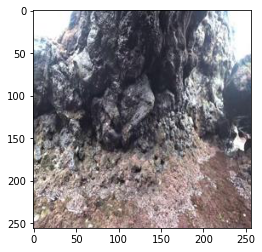

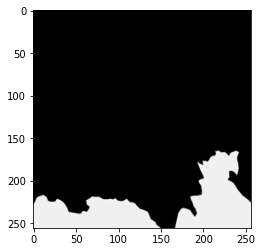

In [ ]:
import random

ix = random.randint(0, len(x_list))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), cmap='gray')
plt.show()

In [ ]:
# IoU
def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

In [ ]:
# UNet
inputs = Input((256, 256, 3))
# s = Lambda(lambda x: x / 255)(inputs)
s = Lambda(lambda x: x)(inputs)

conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(s)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
merge6 = concatenate([up6, conv4])
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
merge7 = concatenate([up7, conv3])
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
merge8 = concatenate([up8, conv2])
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
merge9 = concatenate([up9, conv1])
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[IoU])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(root_path+'/keras_UNet_12.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=50, callbacks=[checkpointer]) # earlystopper, 

Epoch 1/50
295/295 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6958
Epoch 1: val_loss did not improve from inf
295/295 [==============================] - 66s 219ms/step - loss: nan - accuracy: 0.6958 - val_loss: nan - val_accuracy: 0.5407
Epoch 2/50
295/295 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7267
Epoch 2: val_loss did not improve from inf
295/295 [==============================] - 66s 223ms/step - loss: nan - accuracy: 0.7267 - val_loss: nan - val_accuracy: 0.5407
Epoch 3/50
295/295 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7267
Epoch 3: val_loss did not improve from inf
295/295 [==============================] - 66s 223ms/step - loss: nan - accuracy: 0.7267 - val_loss: nan - val_accuracy: 0.5407
Epoch 4/50
295/295 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7267
Epoch 4: val_loss did not improve from inf
295/295 [==============================] - 66s 223ms/step - loss: nan - 

KeyboardInterrupt: ignored

In [ ]:
# model = load_model('model-dsbowl2018.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

5/5 [==============================] - 2s 419ms/step


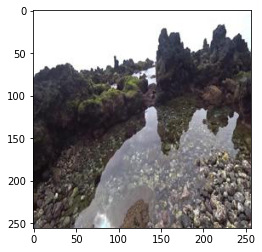

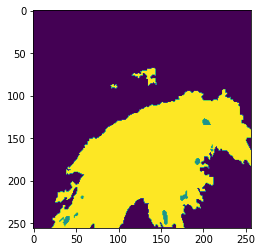

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


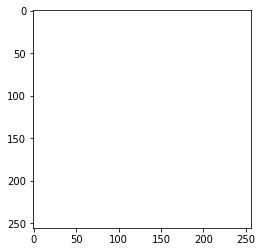

In [ ]:
import random
ix = random.randint(0, len(preds_train))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), cmap='gray')
plt.show()
plt.imshow(np.squeeze(preds_train[ix]))
plt.show()

# Pytorch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

root_path = '/content/drive/MyDrive/StagnantWaterDetection/WATER_Dataset_split'
x_dir = '/train_img/train_256/'
y_dir = '/train_output/MaskImages/mask_256/'

x_list = os.listdir(root_path + x_dir)
x_list = sorted(x_list)
y_list = os.listdir(root_path + y_dir)
y_list = sorted(y_list)
print(len(x_list), len(y_list))

1309 1309


In [2]:
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

num_classes = 3

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

(1000, 3)


KMeans(n_clusters=3)

In [39]:
# dataset 정의

class WaterDataset(Dataset):

    def __init__(self, x_dir, y_dir, x_list, y_list, label_model):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.x_list = x_list
        self.y_list = y_list
        self.label_model = label_model

    def __len__(self): 
        return len(self.x_list)

    def __getitem__(self, index):
        x_fn = self.x_list[index]
        x_fp = os.path.join(self.x_dir, x_fn)
        x_img = Image.open(x_fp).convert('RGB')
        x = np.array(x_img)
        x = self.transform(x)

        y_fn = x_fn.split('.')[0] + '.png'
        y_fp = os.path.join(self.y_dir + y_fn)
        y_img = Image.open(y_fp).convert('RGB')
        y = np.array(y_img)
        label_class = self.label_model.predict(y.reshape(-1, 3)).reshape(256, 256)
        label_class = torch.Tensor(label_class).long()

        return x, label_class

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [40]:
dataset = WaterDataset(root_path+x_dir, root_path+y_dir, x_list, y_list, label_model)
print(len(dataset))
x, y = dataset[0]
print(x.shape, y.shape)

1309
torch.Size([3, 256, 256]) torch.Size([256, 256])


In [25]:
# UNet 구현 (no padding)
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2)

        self.middle = self.conv_block(in_channels=512, out_channels=1024)

        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),          
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X)
        contracting_12_out = self.contracting_12(contracting_11_out)
        contracting_21_out = self.contracting_21(contracting_12_out)
        contracting_22_out = self.contracting_22(contracting_21_out)
        contracting_31_out = self.contracting_31(contracting_22_out)
        contracting_32_out = self.contracting_32(contracting_31_out)
        contracting_41_out = self.contracting_41(contracting_32_out)
        contracting_42_out = self.contracting_42(contracting_41_out)

        middle_out = self.middle(contracting_42_out)

        expansive_11_out = self.expansive_11(middle_out)
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out)
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out)
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1))
        expansive_41_out = self.expansive_41(expansive_32_out)
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1))
        output_out = self.output(expansive_42_out)

        return output_out

In [41]:
model = UNet(num_classes=3)
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape)
print(Y.shape)

Y_pred = model(X)
print(Y_pred.shape)

1309 328
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256])


In [43]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [46]:
# 모델 학습
batch_size = 4
epochs = 50
lr = 0.01

dataset = WaterDataset(root_path+x_dir, root_path+y_dir, x_list, y_list, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNet(num_classes=3).to(device)

# 손실함수
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0

    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        # loss = criterion(nn.Sigmoid(Y_pred), Y)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

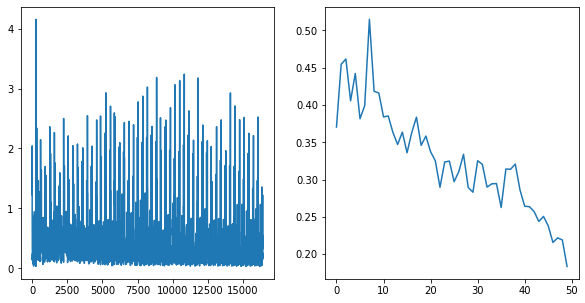

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

plt.show()

In [48]:
model_name = "UNet_256_50.pth"
torch.save(model.state_dict(), root_path + model_name)

In [49]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [54]:
val_dir = '/content/drive/MyDrive/StagnantWaterDetection/WATER_Dataset_split/val_img/val_256/'
val_y_dir = '/content/drive/MyDrive/StagnantWaterDetection/WATER_Dataset_split/val_output/MaskImages/mask_256/'

val_list = os.listdir(val_dir)
val_list = sorted(val_list)
y_list = os.listdir(val_y_dir)
y_list = sorted(y_list)
print(len(val_list), len(y_list))

test_batch_size = 8
dataset = WaterDataset(val_dir, val_y_dir, val_list, y_list, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

166 166
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


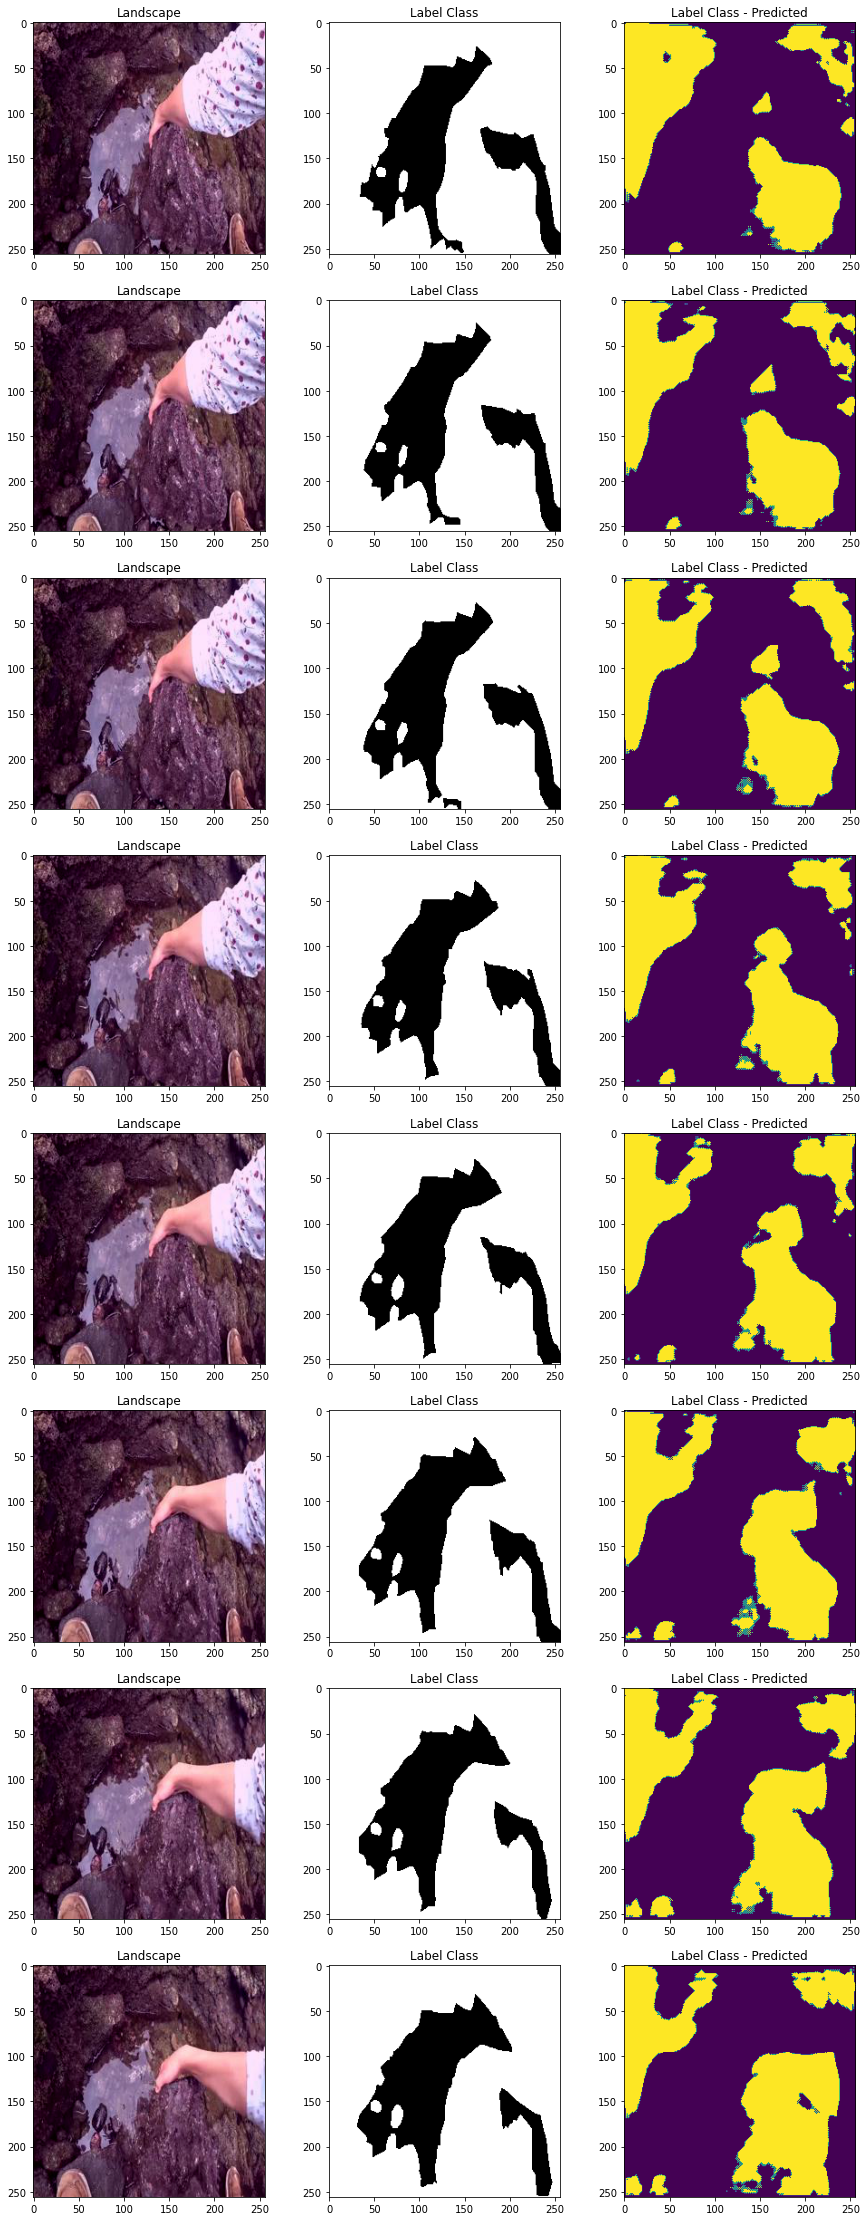

In [56]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='gray')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

In [57]:
print(sum(iou_scores) / len(iou_scores))

0.44313440517696434
